# PCA of Orange data

In [1]:
# Copyright Stephane LASSALVY 2024 - Licence GPL-3
# 
# Disclaimer of Warranty
# ----------------------
# THERE IS NO WARRANTY FOR THE PROGRAM, TO THE EXTENT PERMITTED BY APPLICABLE LAW. EXCEPT WHEN OTHERWISE STATED IN WRITING THE COPYRIGHT HOLDERS AND/OR OTHER PARTIES PROVIDE THE PROGRAM “AS IS” WITHOUT WARRANTY OF 
# ANY KIND, EITHER EXPRESSED OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE. THE ENTIRE RISK AS TO THE QUALITY AND PERFORMANCE OF THE 
# PROGRAM IS WITH YOU. SHOULD THE PROGRAM PROVE DEFECTIVE, YOU ASSUME THE COST OF ALL NECESSARY SERVICING, REPAIR OR CORRECTION.

In [2]:
import pandas as pan
import sklearn as sklearn
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from numpy.polynomial.polynomial import polyfit
import numpy as np

# Importing data

In [3]:
orange_X = pan.read_csv("C:/Users/steph/Documents/Orange/orange_X.csv", decimal=".", delimiter=";")
#ocde_Y = pan.read_csv("C:/Users/steph/Documents/OCDE/ocde_Y.csv", decimal=".", delimiter=";")

# Predictors X data frame, head of data frame and shape

In [4]:
orange_X.head
orange_X.shape

(24, 8)

# Data are centered and scaled

In [5]:
scaler = StandardScaler()
orange_X_Std = scaler.fit_transform(orange_X)
orange_X_Std = pan.DataFrame(orange_X_Std, columns = orange_X.columns, index = orange_X.index)

# Addon functions

In [32]:
# Copyright Stephane LASSALVY 2024 - Licence GPL-3
# 
# Disclaimer of Warranty
# ----------------------
# THERE IS NO WARRANTY FOR THE PROGRAM, TO THE EXTENT PERMITTED BY APPLICABLE LAW. EXCEPT WHEN OTHERWISE STATED IN WRITING THE COPYRIGHT HOLDERS AND/OR OTHER PARTIES PROVIDE THE PROGRAM “AS IS” WITHOUT WARRANTY OF 
# ANY KIND, EITHER EXPRESSED OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE. THE ENTIRE RISK AS TO THE QUALITY AND PERFORMANCE OF THE 
# PROGRAM IS WITH YOU. SHOULD THE PROGRAM PROVE DEFECTIVE, YOU ASSUME THE COST OF ALL NECESSARY SERVICING, REPAIR OR CORRECTION.

def Inertia(data_frame):
# function : Inertia
# Description : Compute the total variance of a numeric data frame 
# Input : data_frame, a numeric pandas data frame
# Return : inertia, the total variance of the data frame / matrix
    X  = np.array(data_frame)
    tX = X.transpose()
    # Compute variance covariance matrix of the data, then inertia
    varcov_matrix = np.matmul(tX, X) / X.shape[0]
    inertia = np.trace(varcov_matrix)
    print(f"Matrix inertia : {np.round(inertia, 3)}")
    return(inertia)

def cross_validation_loo_overall(Y_data_frame, X_data_frame):
# function : cross_validation_loo_overall
# Description : Compute a cross validation criterion for a PLS model with respect to model dimensions. The procedure use a LOO (leave one out methods) 
# Input : Y_data_frame, a numeric pandas data frame for the reponse variables
#         X_data_frame, a numeric pandas data frame for the predictor variables
# Return : a plot of the LOO criterion to assess the best model dimension (super parameter)
    cv = LeaveOneOut()
    PRESS_Vec = []
    for i in range(1, X_data_frame.shape[1] + 1):
        pls = PLSRegression(n_components = i)

        #use LOOCV to evaluate model
        scores = cross_val_score(pls, X = X_data_frame, y  = Y_data_frame, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs=-1)
        PRESS = np.mean(scores**2)
        PRESS_Vec.append(PRESS)
        t = list(range(1, X_data_frame.shape[1]+1, 1))
    fig, ax = plt.subplots()
    ax.plot(t, PRESS_Vec, label = "PRESS")
    ax.set(xlabel='Number of axes', ylabel='PRESS', title=f"optimal PRESS : {min(np.round(PRESS_Vec, 3))} for {PRESS_Vec.index(min(PRESS_Vec)) + 1} axe(s)")
    ax.grid()
    plt.legend()
    plt.show()

def cross_validation_loo_by_response(Y_data_frame, X_data_frame):
# function : cross_validation_loo_by_response
# Description : Compute a cross validation criterion by response variable for a PLS model with respect to model dimensions.
#               The procedure use a LOO (leave one out methods) 
# Input : Y_data_frame, a numeric pandas data frame for the reponse variables
#         X_data_frame, a numeric pandas data frame for the predictor variables
# Return : a plot of the LOO criterions response by response variable to assess the best model dimension (super parameter)
    variables_Y = list(Y_data_frame.columns)
    variables_X = list(X_data_frame.columns)
    cv = LeaveOneOut()
    PRESS_List = []
    for variable in variables_Y:
        print(f"* Computation for variable {variable}")
        PRESS_Vec = []
        for i in range(1, X_data_frame.shape[1] + 1):
            print(f"- Computation with {i} axe(s)")
            pls = PLSRegression(n_components = i)
            #use LOOCV to evaluate model
            scores = cross_val_score(pls, X = X_data_frame, y = Y_data_frame[variable], scoring = 'neg_mean_absolute_error', cv = cv, n_jobs=-1)
            PRESS = np.mean(scores**2)
            PRESS_Vec.append(PRESS)
        PRESS_List.append(PRESS_Vec)
    fig, ax = plt.subplots()
    t = list(range(1, X_data_frame.shape[1]+1, 1))
    for i in range(0, len(variables_Y)):
        print(f"Optimal number of axes for variable n°{i + 1} ({variables_Y[i]}) : {PRESS_List[i].index(min(PRESS_List[i])) + 1}")
        ax.plot(t, PRESS_List[i], label = variables_Y[i])
    ax.set(xlabel='Number of axes', ylabel='PRESS', title="PRESS for each response variable")
    plt.legend()
    ax.grid()
    plt.show()

def projection(data_frame, axes, varcov = True):
# function : projection
# Description : Compute the projection of a numeric data frame
# on a vector subspace generated by the columns of the data frame axes
# Projection can be made following the euclidean scalar product with metric D = Id,
# or using the variance-covariance metric : D = 1/n * Id, where n is the sample size. 
# Input : data_frame, numeric pandas data frame to be projected
#         axes, numeric pandas data frame which columns generate the supbspace of projection
#         varcov, boolean value, if varcov == True, the scalar product use D = 1/n * Id where n is the sample size,
#         if varcov = True, the usual euclidean scalar product is used with D = Id. 
# Return : projection the projection of data_frame onto axes
    # Y data to be projected, X data to project Y onto
    Y           = np.array(data_frame)
    X           = np.array(axes)
    # Choosing the metric D
    if varcov == True:
        den = X.shape[0]
    else:
        den = 1
    # Computing the projection PY = X(tX*X)^{-1}tXDY
    tX          = X.transpose()
    tXDX        = np.matmul(tX, X) / den
    inv_tXDX    = np.linalg.inv(tXDX)
    tXDY        = np.matmul(tX, Y) / den
    inv_tXDX_tXDY = np.matmul(inv_tXDX, tXDY)
    projection = np.matmul(X, inv_tXDX_tXDY)
    projection = pan.DataFrame(projection, columns = data_frame.columns, index = data_frame.index)
    return(projection)

def individuals_map(x_scores, axes_to_plot = [1,2]):
# function : individuals_map
# Description : Plot the projection of the individuals on the factorial plane (t_i, t_j)
# Input : x_scores, numeric pandas data frame of scores
#         axes_to_plot, a two elements list [i, j] with the indexes of the scores to use. 
# Return : plot of the X data on the subspace generated by (t_i, t_j)
    components_to_plot = ["PC" + j for j in map(str, axes_to_plot)]
    t_to_plot = ["t" + j for j in map(str, axes_to_plot)]
    # Plot the choosen scores
    fig, ax = plt.subplots(figsize=(8, 6))
    x = x_scores[components_to_plot[0]].to_list()
    y = x_scores[components_to_plot[1]].to_list()
    ax.scatter(x = x, y = y, color="darkgreen")
    ax.set_xlabel(t_to_plot[0])
    ax.set_ylabel(t_to_plot[1])
    # Annotate the points
    for i,txt in enumerate(x_scores.index):
        ax.annotate(txt, (x[i] + 0.05, y[i] + 0.05))
    # Add horizontal and vertical axes and title
    plt.vlines(x = 0, ymin = min(y)-0.5, ymax = max(y)+0.5, color = "black", linestyles = "dashed", facecolor = None)
    plt.hlines(y = 0, xmin = min(x)-0.5, xmax = max(x)+0.5, color = "black", linestyles = "dashed", facecolor = None)
    plt.title("Factorial map for individuals")
    plt.show()

def coordinates(data_frame, axes, varcov = True):
# function : coordinates
# Description : Compute the coordinates of columns of a numeric data frame on the
# axes given by the columns of the data frame axes
# Projection can be made following the euclidean scalar product with metric D = Id,
# or using the variance-covariance metric : D = 1/n * Id, where n is the sample size. 
# Input : data_frame, numeric pandas data frame to be projected
#         axes, numeric pandas data frame which columns generate the supbspace of projection
#         varcov, boolean value, if varcov == True, the scalar product use D = 1/n * Id where n is the sample size,
#         if varcov = True, the usual euclidean scalar product is used with D = Id. 
# Return : X_coordinates the coordinates of the columns of data_frame on the columns of axes
    X = np.array(data_frame)
    tX = X.transpose()
    scaler = StandardScaler(with_mean= True, with_std = True)
    scaled_axes = scaler.fit_transform(axes)
    # Choosing the metric D
    if varcov == True:
        den = X.shape[0]
    else:
        den = 1      
    X_coordinates = np.matmul(tX, scaled_axes) / X.shape[0]
    X_coordinates = pan.DataFrame(X_coordinates, columns = axes.columns, index = data_frame.columns)
    return(X_coordinates)
    
def variables_map(var_coordinates, axes_to_plot = [1, 2], draw_circle = True):
# function : variables_map
# Description : Plot the projection of the predictors and traget variables
#               on the factorial plane (t_i, t_j)
# Input : var_coordinates, numeric pandas data frame of the variable coordinates
#         axes_to_plot, a two elements list [i, j] with the indexes of the coordinates to use.# Return : plot of the X and Y variables on the subspace generated by (t_i, t_j)
    components_to_plot = ["PC" + j for j in map(str, axes_to_plot)]
    t_to_plot = ["t" + j for j in map(str, axes_to_plot)]
    if "color" not in var_coordinates.columns:
        var_coordinates["color"] = "black"
        
    # Plot a variable factor map for the first two dimensions.
    fig, ax = plt.subplots(figsize=(8, 8))
    x = var_coordinates[components_to_plot[0]].to_list()
    y = var_coordinates[components_to_plot[1]].to_list()
    # Draw the arrows for each variable, color them whether they belong to Y or X and annotate them
    txt = var_coordinates.index
    colors = var_coordinates["color"].to_list()
    for i in range(0, var_coordinates.shape[0]):
        ax.arrow(0,
                 0,     # Start the arrow at the origin
                 x[i],  #0 for PC1
                 y[i],  #1 for PC2
                 head_width  = 0.01,
                 head_length = 0.01, )
        plt.text(x[i] + 0.05,
                 y[i] + 0.05,
                 txt[i], color = colors[i])
    # Add label to axes
    ax.set_xlabel(t_to_plot[0])
    ax.set_ylabel(t_to_plot[1])
    if draw_circle == True:
        # Add horizontal and vertical axes
        plt.vlines(x = 0, ymin = -1, ymax = 1, color = "black", linestyles = "dashed", facecolor = None)
        plt.hlines(y = 0, xmin = -1, xmax = 1, color = "black", linestyles = "dashed", facecolor = None)
        # Add a unit circle for scale
        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an), color ="black")
        plt.axis('equal')
        plt.xlim([-1.1, 1.1])
        plt.ylim([-1.1, 1.1])
    else:
        # Add horizontal and vertical axes
        plt.vlines(x = 0, ymin = min(y) - 0.1, ymax = max(y) + 0.1, color = "black", linestyles = "dashed", facecolor = None)
        plt.hlines(y = 0, xmin = min(x) - 0.1, xmax = max(x) + 0.1, color = "black", linestyles = "dashed", facecolor = None)
        plt.xlim([min(x) - 0.1, min(x) + 0.1])
        plt.ylim([min(y) - 0.1, min(y) + 0.1])
    plt.show()

def fit_PLS_by_dimension(responses_Y, predictors_X):
# function : fit_PLS_by_dimension
# Description : fit several PLS models for dimension = 1, 2, ... to dimension = ncol(predictors_X)
# Input : responses_Y data frame, numeric pandas data frame for the response variables
#         responses_X data frame, numeric pandas data frame for the predictor variables
# Return : output, a dictionary gathering the different results :
#                  'Dimensions': the different dimensions possible for the PLS models,
#                  'Y_inertia': total inertia for predictors Y data frame,
#                  'X_inertia': total inertia for predictors X data frame,
#                  'Y fitted_list': list of fitted values for Y by models dimension,
#                  'X fitted_list': list of fitted values for X by models dimension,
#                  'X_fitted_inertia_list': X fitted dataframe inertia by models dimension,
#                  'X_fitted_inertia_pct_list': X fitted dataframe inertia in percent by models dimension,
#                  'Y_fitted_inertia_list': Y fitted dataframe inertia by models dimension,
#                  'Y_fitted_inertia_pct_list': Y fitted dataframe inertia in percent by models dimension,
#                  'residuals_list': residuals data frame by model dimentions,
#                  'MSE_list': MSE by model dimentions,
#                  'RMSE_list': RMSE by model dimensions,
#                  'B_coefficients_matrix': data frame B of beta coefficients by model dimensions,
#                  'Beta_list': list of beta coefficients by model dimensions
    print("debut fonction")
    # Reconstruted data with the successive models (Dimension = 1, 2, 3, ..., ncol(X)
    Y_fitted_list = []
    X_fitted_list = []
    # Y and X explained inertia for fitted Y and X, in raw form or in percent
    Y_fitted_inertia_list = []
    Y_fitted_inertia_pct_list = []
    X_fitted_inertia_list = []
    X_fitted_inertia_pct_list = []
    # Residuals list
    residuals_list = []
    # MSE and RMSE lists
    MSE_list = []
    RMSE_list =  []
    # Regression coefficients
    B = pan.DataFrame()
    Beta_list = []
    
    # Y and X inertias
    print("total variance of matrix Y:")
    Y_inertia = Inertia(responses_Y)
    print("total variance of matrix X:")
    X_inertia = Inertia(predictors_X)

    print("Format of predictors matrix Y:")
    print(responses_Y.shape)
    
    print("Format of predictors matrix X:")
    print(predictors_X.shape)
    
    print("-- Fitting the model for the different dimensions --")
    for i in range(1, predictors_X.shape[1] + 1):
        print(f"Dimension = {i} :")
        print("-----------------")
        pls = PLSRegression(n_components =  i)
        pls.fit(X = predictors_X, y = responses_Y)

        #Y_fitted values
        Y_fitted_values = pan.DataFrame(pls.predict(predictors_X), index = responses_Y.index, columns= responses_Y.columns)
        Y_fitted_list.append(Y_fitted_values)

        # t scores of the PLS
        x_scores = pls.x_scores_
       
        # Projection of X on the t scores
        X_fitted = projection(predictors_X, x_scores)
        X_fitted_list.append(X_fitted)
        X_fitted_inertia  = Inertia(X_fitted)
        X_fitted_inertia_pct = X_fitted_inertia / X_inertia * 100
        print(f"Y : % of explained inertia : {np.round(X_fitted_inertia_pct, 3)} %")
        X_fitted_inertia_list.append(X_fitted_inertia)
        X_fitted_inertia_pct_list.append(X_fitted_inertia_pct)
    
        # % Explained inertia for X
        Y_fitted_inertia = Inertia(Y_fitted_values)
        Y_fitted_inertia_pct = Y_fitted_inertia / Y_inertia * 100
        print(f"Y : % of explained inertia : {np.round(Y_fitted_inertia_pct, 3)} %")
        Y_fitted_inertia_list.append(Y_fitted_inertia)
        Y_fitted_inertia_pct_list.append(Y_fitted_inertia_pct)
    
        # Residuals
        residual_matrix = responses_Y - Y_fitted_values
        residuals_list.append(residual_matrix)

        # MSE and RMSE
        MSE  = Inertia(residual_matrix)
        RMSE = np.sqrt(MSE)
        print(f"MSE = {round(MSE, 3)}, RMSE = {np.round(RMSE, 3)}")    
        MSE_list.append(MSE)
        RMSE_list.append(np.sqrt(MSE))

        # Regression coefficient for the X predictors
        Beta  = np.array(pls.coef_)
        tBeta = Beta.transpose()
        tBeta = pan.DataFrame(tBeta, columns = [j + f"{i}" for j in responses_Y.columns.to_list()])
        B     = pan.concat([B, tBeta], axis = 1)
        Beta_list.append(tBeta)

    # Naming B rows
    B.index = predictors_X.columns
    
    # Gathering the different results
    output = {'Model dimensions': list(range(1, predictors_X.shape[1]+1)),
              'Y_shape:': responses_Y.shape,
              'Y_variables': responses_Y.columns,
              'Y_individuals' : responses_Y.index,
              'Y_inertia': Y_inertia,
              'X_shape:': predictors_X.shape,
              'X_variables': predictors_X.columns,
              'X_individuals' : predictors_X.index,
              'X_inertia': X_inertia,
              'Y_fitted_list': Y_fitted_list,
              'X_fitted_list': X_fitted_list,
              'X_fitted_inertia_list': X_fitted_inertia_list,
              'X_fitted_inertia_pct_list': X_fitted_inertia_pct_list,
              'Y_fitted_inertia_list': Y_fitted_inertia_list,
              'Y_fitted_inertia_list_pct': Y_fitted_inertia_pct_list,
              'residuals_list': residuals_list,
              'MSE_list': MSE_list,
              'RMSE_list': RMSE_list,
              'B_coefficients_matrix': B,
              'Beta_list': Beta_list}
    return output

def MSE_plot(MSE_list):
# function : MSE_plot
# Description : plot MSE and RMSE vs Model dimension
# Input : MSE_list, list of the MSE for the models with dimension 1 to number of predictors
# Return : plot MSE and RMSE vs Model dimension
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
    x = range(1, len(MSE_list) + 1)
    ax[0].bar(x, MSE_list)
    ax[1].bar(x, np.sqrt(MSE_list))
    ax[0].tick_params(axis='x', labelrotation = 90)
    ax[1].tick_params(axis='x', labelrotation = 90)
    ax[0].set(xlabel = 'Model dimension', ylabel = "MSE", title = f"MSE vs Model dimension")
    ax[1].set(xlabel = 'Model dimension', ylabel = "RMSE", title = f"RMSE vs Model dimension") 
    # Show graph
    plt.show()

def Beta_vs_dim_plot(Beta_data_frame, response_names):
# function : Beta_vs_dim_plot
# Description : plot predicted vs observation data
# Input : Beta_data_frame data frame, numeric pandas data frame Beta coeefficients
#         response_names, list of the response variables names
# Return : plot of the Beta values vs the dimensions of the PLS models
    # Plotting coefficients
    t = list(range(1, Beta_data_frame.shape[0] + 1))
    predictors_names = Beta_data_frame.index.tolist()
    for j in response_names:
        selection = [f"{j}" + f"{k}" for k in t]
        Beta_sel = Beta_data_frame[selection]
        Beta_sel_ctrd = scale(Beta_sel, with_mean = True, with_std = False, axis = 0)
        Beta_sel_ctrd = pan.DataFrame(Beta_sel_ctrd, columns = Beta_sel.columns, index = Beta_sel.index)
        fig, ax = plt.subplots()
        for k in range(0, Beta_sel_ctrd.shape[0]):
            ax.plot(t, Beta_sel_ctrd.iloc[:, [k]], label = predictors_names[k])     

        ax.set(xlabel='Number of axes', ylabel='Beta coefficients', title = f"Coefficients for variable {j}")
        plt.legend()
        ax.grid()
        plt.show()

def cumulated_inertia_plot(inertia_list, total_inertia, df = "Y"):
# function : cumulated_inertia_plot
# Description : plot explained inertia vs model dimensions
# Input : inertia_list, list of the explained inertia
#         total inertia, value of the inertia of the original data frame
#         df, character specifying for which data X of Y the explained inertias are plotted
# Return : plot of the Beta values vs the dimensions of the PLS models
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
    x = range(1, len(inertia_list) + 1)
    # Graph for cumulated inertia
    ax[0].bar(x, inertia_list)
    ax[0].tick_params(axis='x', labelrotation = 90)
    ax[0].set(xlabel='Model dimension', ylabel=f"{df} variance explained", title=f"{df} variance explained in % vs Model dimension") 
    ax[0].hlines(y = 0.8 * total_inertia, xmin = min(x) - 1, xmax = max(x) + 1, color = "black", linestyles = "dashed", facecolor = None)
    # Graph for cumulated inertia in percent
    inertia_pct_list = inertia_list / total_inertia * 100
    ax[1].bar(x, inertia_pct_list)
    ax[1].tick_params(axis='x', labelrotation = 90)
    ax[1].set(xlabel='Model dimension', ylabel=f"{df} variance explained in %", title=f"{df} variance explained in % vs Model dimension")
    ax[1].hlines(y = 80, xmin = min(x) - 1, xmax = max(x) + 1, color = "black", linestyles = "dashed", facecolor = None)
    # Show graph
    plt.show()

def coefficients_plot(pls_model, responses_names, predictors_names):
# function : coefficients_plot
# Description : plot explained inertia vs model dimensions
# Input : pls_model model of a given dimension which beta coefficients are to be displayed
#         responses_names, index of the names of the response variables
#         predictors_names, index of the names of the predictor variables
# Return : for eache response variable, plot of the Beta values vs each predictor variables sorted by absolute values of the coefficients
# Function : coefficients_plot
    Coefs = np.array(pls_model.coef_)
    # Beta coefficients for all response variables
    Beta = Coefs.transpose()
    Beta  = pan.DataFrame(Beta, columns = responses_names, index = predictors_names)
    colors = np.linspace(0, 1, Beta.shape[0])
    print("Predictors regression coefficients")
    print(Beta)
    # Display barplots
    for j in responses_names:
        predictors_names_tuple = tuple(predictors_names)
        values     = Beta[j].tolist()
        abs_values = np.abs(values)
        coefs_j    = pan.DataFrame({'predictors': predictors_names_tuple, 'coef': values, 'abs_coef': abs_values})
        coefs_j    = coefs_j.sort_values(by = ["abs_coef"], ascending = False)
    # Create bars
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
    ax[0].bar(coefs_j["predictors"], coefs_j["coef"])
    ax[1].bar(coefs_j["predictors"], coefs_j["abs_coef"])
    ax[0].tick_params(axis='x', labelrotation=90)
    ax[1].tick_params(axis='x', labelrotation=90)
    ax[0].set(xlabel='Predictors', ylabel="Regression coefficients", title=f"Regression coefficients for {j}")
    ax[1].set(xlabel='Predictors', ylabel="Absolute value of coefficients", title=f"Absolute value of coefficients for {j}") 
    # Show graph
    plt.show()

def Y_vs_xscores_plot(responses_data_frame, x_scores_data_frame):
# Function Y_vs_xscores_plot
# Description : plot predicted vs observation data
# Input : responses_data_frame, data frame, numeric pandas data frame for the observed response variables
#         x_scores_data_frame, data frame of the scores for the predictor variables
# Return : plot of the responses variables vs predictors scores axes
    for j in responses_data_frame.columns.tolist():
                for k in range(0, x_scores_data_frame.shape[1] - 1):
                    fig, ax = plt.subplots()
                
                    x = x_scores_data_frame.iloc[:, k].tolist()
                    y = responses_data_frame[j].tolist()

                    r = np.corrcoef(x, y)[0, 1]
                    rsquared = r ** 2
                
                    ax.scatter(x = x, y = y)
      
                    for i,txt in enumerate(x_scores.index):
                        ax.annotate(txt, (x[i] + 0.05, y[i] + 0.05))
                
                    # Regression fit with polyfit
                    b, m = polyfit(x, y, 1)

                    # Drawing of the regression line
                    x_reg = np.linspace(start = min(x), stop = max(x), num = 50)
                    ax.plot(x_reg, m * x_reg + b)

                    ax.set(xlabel=f"t axis n° {k+1}", ylabel=f"Variable {j}", title = f"Variable {j} vs X Score t{k+1}, corr = {np.round(r, 3)}, rsquared = {np.round(rsquared, 3)}")
                    ax.grid()
                    plt.show()

def yscores_vs_xscores_plot(x_scores_data_frame, y_scores_data_frame):
# Function yscores_vs_xscores_plot
# Description : plot predicted vs observation data
# Input : x_scores_data_frame, data frame of the scores for the predictor variables
#         y_scores_data_frame, data frame of the scores for the response variables
# Return : plot of the responses variables vs predictors scores axes
    for k in range(0, x_scores_data_frame.shape[1]):
        fig, ax = plt.subplots()
        x = x_scores_data_frame.iloc[:, k].tolist()
        y = y_scores_data_frame.iloc[:, k].tolist()
        std_x = np.std(x, ddof = 1)
        std_y = np.std(y, ddof = 1)
        cov_xy = np.cov(x,y, ddof = 1)[0, 1]
        r = np.corrcoef(x, y)[0, 1]
        rsquared = r ** 2
        print(f"Dimension {k + 1} : cov(t,u) = {np.round(cov_xy, 3)}, corr(t,u) = {np.round(r, 3)}, stdev(t) = {np.round(std_x, 3)}, stdev(u) = {np.round(std_y, 3)}, rsquared(t,u) = {np.round(rsquared, 3)}")
        ax.scatter(x = x, y = y)
        # Annotate points
        for i,txt in enumerate(x_scores.index):
            ax.annotate(txt, (x[i] + 0.05, y[i] + 0.05))
        # Regression fit with polyfit
        b, m = polyfit(x, y, 1)
        # Drawing of the regression line
        x_reg = np.linspace(start = min(x), stop = max(x), num = 50)
        plt.plot(x_reg, m * x_reg + b)
        ax.set(xlabel=f"t axis n° {k+1}", ylabel=f"u axis n° {k+1}", title = f"Y scores u{k+1} vs X scores t{k+1}, corr = {np.round(r, 3)}, rsquared = {np.round(rsquared, 3)}")
        ax.grid()
        plt.show()

def predicted_vs_observed_plot(Y, Y_fitted):
# function : predicted_vs_observed_plot
# Description : plot predicted vs observation data
# Input : Y data frame, numeric pandas data frame for the observed response variables
#         Y_fitted data frame, numeric pandas data frame for the predicted response variables
# Return : plot of the predicted values vs the observed values of the response variables
        txt = Y.columns
        for j in txt:
            fix, ax = plt.subplots()
            x = Y[j].to_list()
            y = Y_fitted[j].to_list()
            ax.scatter(x, y)
            r = np.corrcoef(x, y)[0,1]
            rsquared = r ** 2
            for i,txt in enumerate(Y.index):
                ax.annotate(txt, (x[i] + 0.05, y[i] + 0.05))
            x_reg = np.linspace(min(Y[j]), max(Y[j]), 50)
            plt.plot(x_reg, x_reg)
            ax.set(xlabel=f"Observed values", ylabel=f"Predicted values", title = f"Predicted vs observed values for {j}, r = {np.round(r, 3)}, rsquared = {np.round(rsquared, 3)}")
            plt.show()
            
def residuals_vs_fitted_values_plot(residuals_data_frame, fitted_values_data_frame):
# Function residuals_vs_fitted_values_plot
# Description : residuals vs predicted values
# Input : residuals_data_frame, data frame of the residuals for each response variables
#         fitted_values_data_frame, data frame of the predicted values for each response variables
# Return : for each response variable, plot of the residuals vs the predicted values
    for j in residuals_data_frame.columns.tolist():
        fig, ax = plt.subplots()
        x = fitted_values_data_frame[j].tolist()
        y = residuals_data_frame[j].tolist()
        individuals = residuals.index.tolist()
        ax.scatter(x = x, y = y)
        # Annotate points
        for i,txt in enumerate(individuals):
            ax.annotate(txt, (x[i] + 0.05, y[i] + 0.05))
        ax.set(xlabel=f"Fitted values", ylabel=f"Residuals", title = f"Residuals vs fitted for {j}")
        # Add horizontal and vertical axes
        plt.hlines(y = 0, xmin = min(x)-0.5, xmax = max(x)+0.5, color = "black", linestyles = "dashed", facecolor = None)
        # Show graph
        plt.show()

# Addon functions for PCA analysis
def variance_ratios_plot(variance_ratios):
# function : variance_ratios_plot
# Description : plot variance_ratios from PCA
# Input : variance ratios  list
# Return : plot variance_ratios_ and cumulative variance ratios
    cumul_variance_ratios = np.cumsum(variance_ratios)
    x = range(1, len(variance_ratios) + 1)
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
    x = range(1, len(variance_ratios) + 1)
    ax[0].bar(x, variance_ratios)
    ax[1].bar(x, cumul_variance_ratios)
    ax[0].tick_params(axis='x', labelrotation = 90)
    ax[1].tick_params(axis='x', labelrotation = 90)
    ax[1].hlines(y = 0.80, xmin = min(x) - 1, xmax = max(x) + 1, color = "black", linestyles = "dashed", facecolor = None)
    ax[0].set(xlabel = 'Model dimension', ylabel = "Variance ratios", title = f"Variance ratios vs dimension")
    ax[1].set(xlabel = 'Model dimension', ylabel = "cum. variance_ratios", title = f"Cum. variance_ratios vs dimension") 
    # Show graph
    plt.show()


# Fitting pls models with tuning parameter (number of axes) from 1 to number of columns of X

In [33]:
pls_models = fit_PLS_by_dimension(predictors_X = orange_X_Std, responses_Y = orange_X_Std)

debut fonction
total variance of matrix Y:
Matrix inertia : 8.0
total variance of matrix X:
Matrix inertia : 8.0
Format of predictors matrix Y:
(24, 8)
Format of predictors matrix X:
(24, 8)
-- Fitting the model for the different dimensions --
Dimension = 1 :
-----------------
Matrix inertia : 3.998
Y : % of explained inertia : 49.979 %
Matrix inertia : 3.998
Y : % of explained inertia : 49.979 %
Matrix inertia : 4.002
MSE = 4.002, RMSE = 2.0
Dimension = 2 :
-----------------
Matrix inertia : 5.889
Y : % of explained inertia : 73.609 %
Matrix inertia : 5.889
Y : % of explained inertia : 73.609 %
Matrix inertia : 2.111
MSE = 2.111, RMSE = 1.453
Dimension = 3 :
-----------------
Matrix inertia : 6.994
Y : % of explained inertia : 87.427 %
Matrix inertia : 6.994
Y : % of explained inertia : 87.427 %
Matrix inertia : 1.006
MSE = 1.006, RMSE = 1.003
Dimension = 4 :
-----------------
Matrix inertia : 7.833
Y : % of explained inertia : 97.911 %
Matrix inertia : 7.833
Y : % of explained inerti

# Total variance (inertia) of predictors X data

In [34]:
X_Inertia = Inertia(orange_X_Std)

Matrix inertia : 8.0


# Cross validation using Leave one out method for the overall Y responses data

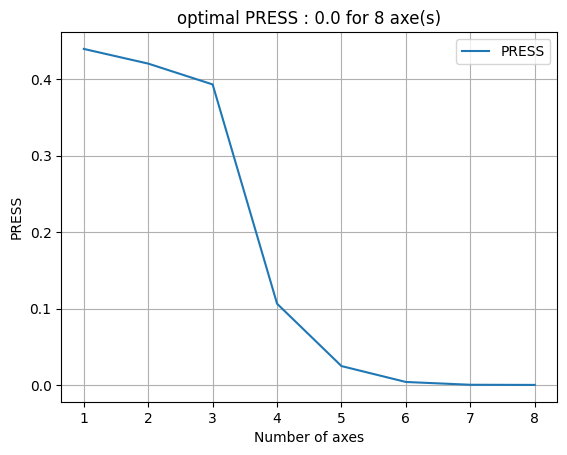

In [35]:
cross_validation_loo_overall(Y_data_frame = orange_X_Std, X_data_frame = orange_X_Std)

# Cross validation using Leave one out method for each response from the Y responses data frame

* Computation for variable COND
- Computation with 1 axe(s)
- Computation with 2 axe(s)
- Computation with 3 axe(s)
- Computation with 4 axe(s)
- Computation with 5 axe(s)
- Computation with 6 axe(s)
- Computation with 7 axe(s)
- Computation with 8 axe(s)
* Computation for variable SiO2
- Computation with 1 axe(s)
- Computation with 2 axe(s)
- Computation with 3 axe(s)
- Computation with 4 axe(s)
- Computation with 5 axe(s)
- Computation with 6 axe(s)
- Computation with 7 axe(s)
- Computation with 8 axe(s)
* Computation for variable Na
- Computation with 1 axe(s)
- Computation with 2 axe(s)
- Computation with 3 axe(s)
- Computation with 4 axe(s)
- Computation with 5 axe(s)
- Computation with 6 axe(s)
- Computation with 7 axe(s)
- Computation with 8 axe(s)
* Computation for variable K
- Computation with 1 axe(s)
- Computation with 2 axe(s)
- Computation with 3 axe(s)
- Computation with 4 axe(s)
- Computation with 5 axe(s)
- Computation with 6 axe(s)
- Computation with 7 axe(s)
- Computa

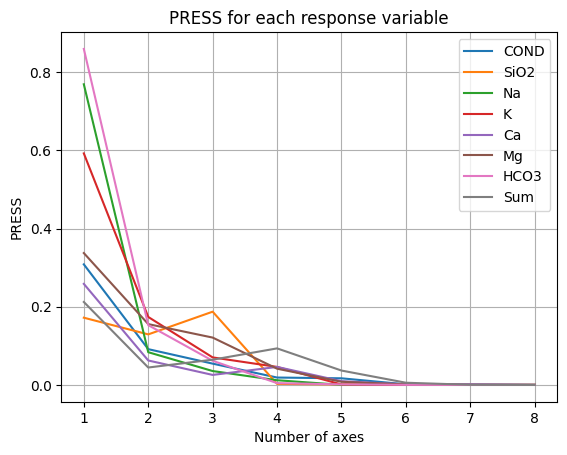

In [36]:
cross_validation_loo_by_response(Y_data_frame = orange_X_Std, X_data_frame = orange_X_Std)

# MSE vs model dimension (number of axes)

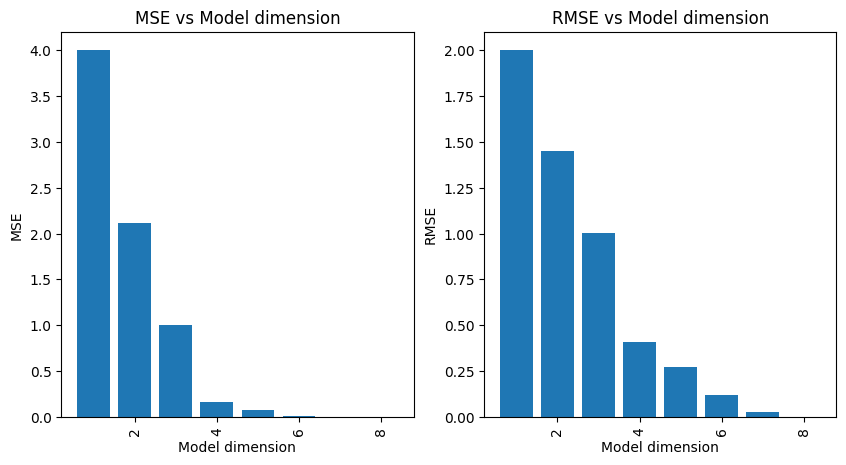

In [37]:
MSE_plot(pls_models["MSE_list"])

# Cumulated explained variance vs model dimension for the X predictors data

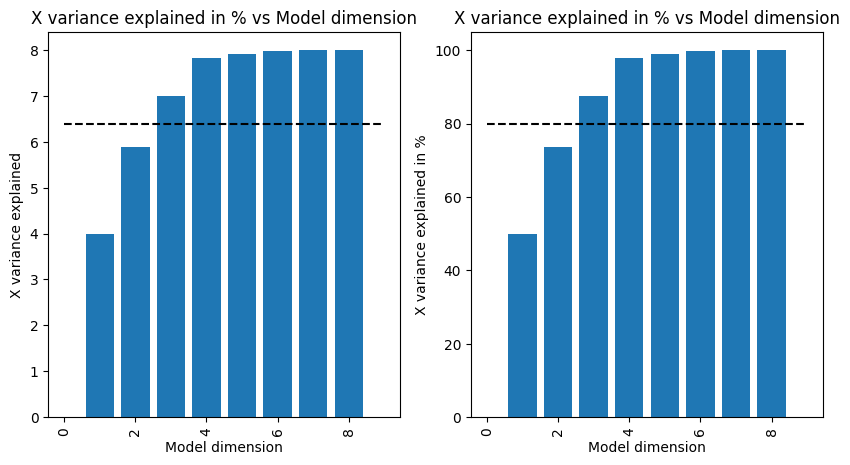

In [38]:
cumulated_inertia_plot(inertia_list= pls_models["X_fitted_inertia_list"], total_inertia=pls_models["X_inertia"], df="X")

# Fitting a PCA

In [39]:
# Fitting PCA decomposition
pca = PCA()
pca.fit(orange_X_Std)

PCA()

# Variance ratios

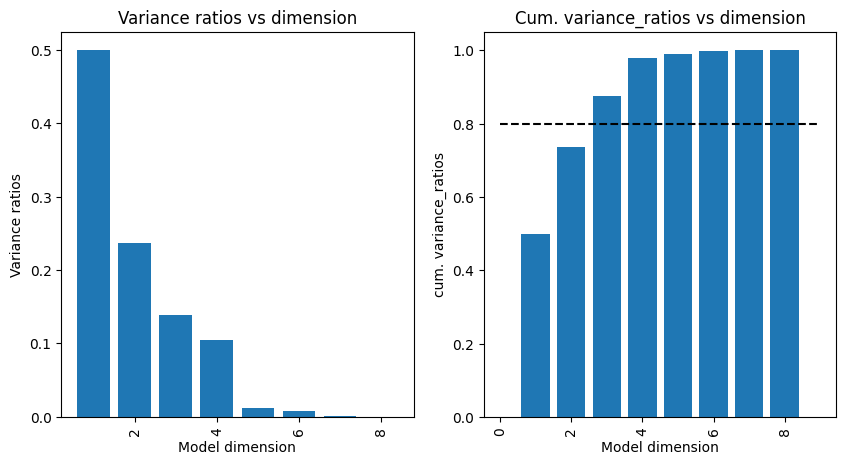

PCA(n_components=3)

In [40]:
variance_ratios_plot(pca.explained_variance_ratio_)
Dimension = 3
pca = PCA(n_components= Dimension)
pca.fit(orange_X_Std)

# Scores

In [41]:
scores = pan.DataFrame(pca.transform(orange_X_Std), columns = ["PC" + j for j in list(map(str, range(1, Dimension + 1)))], index = orange_X_Std.index)
print(scores)

        PC1       PC2       PC3
A -0.405926 -0.188402  0.305617
B -0.498609 -0.508990  0.005753
C -1.182103  1.283029 -0.625690
D -1.319982 -1.129206 -0.667636
E -0.166099  0.729891  1.008993
F -1.455765 -0.907907 -0.735785
G -1.005253  0.221863  0.040100
H -0.428297 -0.343046  1.440402
I  0.338223  0.240409  2.659062
J -1.125025  0.073235 -0.415364
K  4.359416 -0.134664 -0.390882
L -0.084802 -0.312545  0.025304
M  5.345428  0.120380 -0.284939
N -0.841345 -0.977098 -0.387723
O  1.198933 -0.504533 -0.156110
P  5.353575 -0.008244 -0.630090
Q -1.290992 -0.689938 -0.831045
R -1.147384  5.689714 -1.592908
S -0.894389 -1.040946 -0.386470
T -0.544351 -0.565042 -0.221568
U -0.687840  1.379821  3.045209
V -1.519597 -1.372018 -0.799211
W -0.531068  0.033398  0.294764
X -1.466749 -1.089160 -0.699784


# % of total variance explained

In [42]:
print(f"X reconstitué par les axes : % inertie = {np.round(Inertia(projection(orange_X_Std, scores)) / X_Inertia * 100, 3)} %")

Matrix inertia : 6.994
X reconstitué par les axes : % inertie = 87.427 %


# Loadings

In [43]:
# loadings
loadings = pan.DataFrame(np.transpose(pca.components_), columns = ["PC" + j for j in list(map(str, range(1, Dimension + 1)))], index = orange_X_Std.columns)
print(loadings)

           PC1       PC2       PC3
COND  0.493156  0.019578 -0.017303
SiO2 -0.056139  0.702034  0.025777
Na   -0.022313  0.229348  0.700748
K     0.041012  0.672980 -0.283612
Ca    0.490445 -0.021221 -0.131672
Mg    0.486416  0.007148 -0.077524
HCO3  0.174260  0.013805  0.633012
Sum   0.493926  0.023889  0.059170


# Individuals maps for axes 1,2 and 3

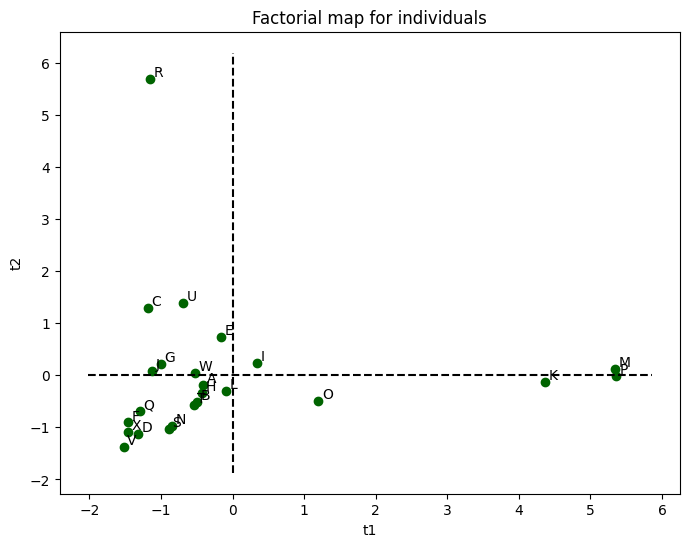

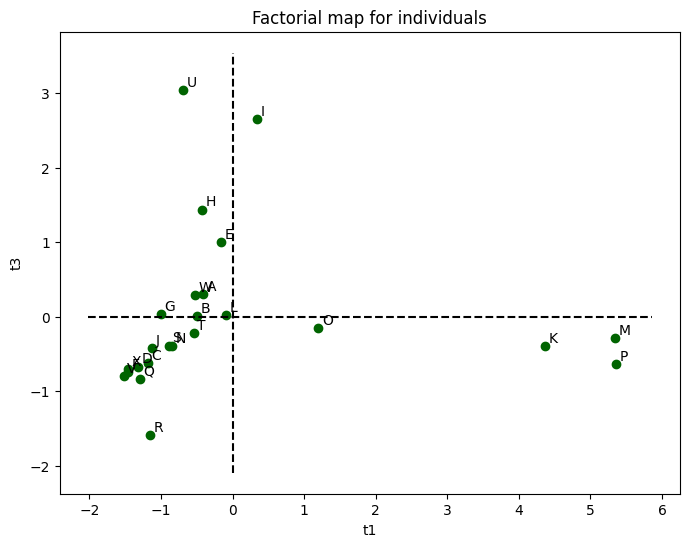

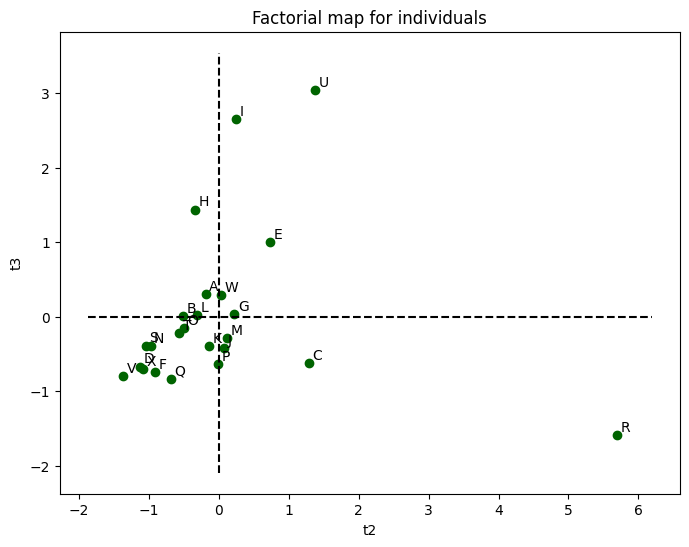

In [44]:
# individuals map, axes 1, 2
individuals_map(scores, axes_to_plot= [1, 2])

# individuals map, axes 1, 3
individuals_map(scores, axes_to_plot= [1, 3])

# individuals map, axes 2, 3
individuals_map(scores, axes_to_plot= [2, 3])

# Correlation circles for axes 1,2 and 3

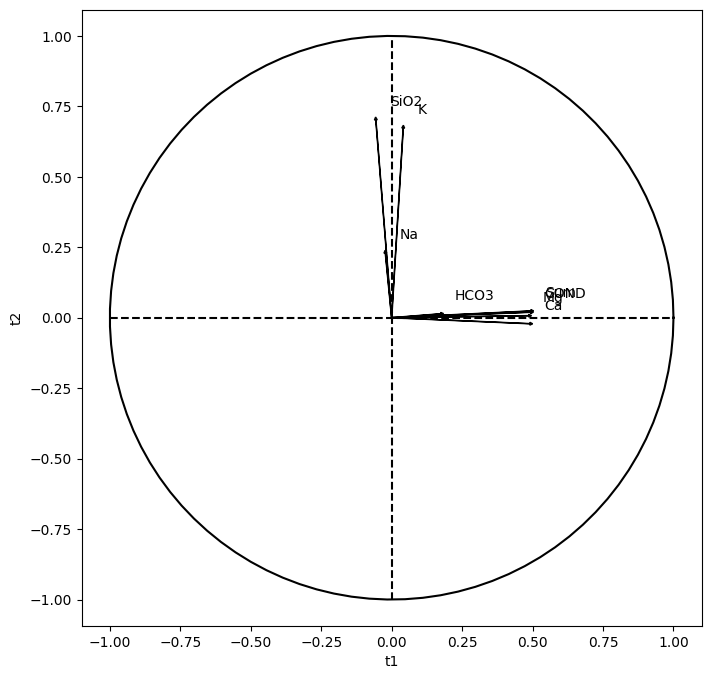

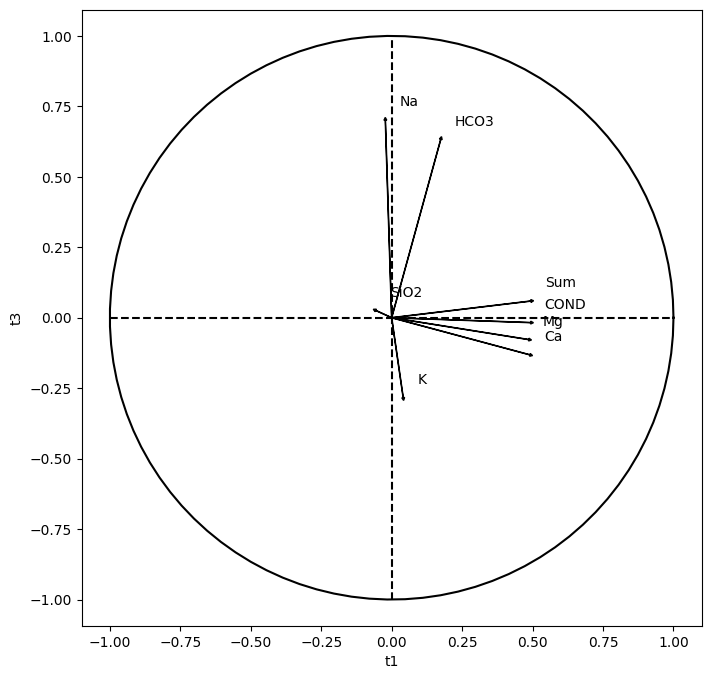

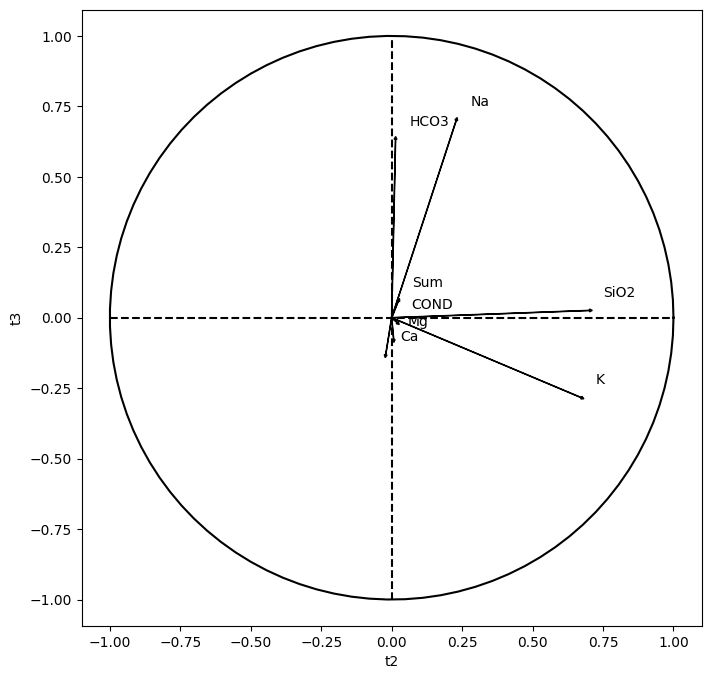

In [45]:
# correlation circle axes 1, 2
variables_map(loadings, axes_to_plot= [1, 2])

# correlation circle axes 1, 3
variables_map(loadings, axes_to_plot= [1, 3])

# correlation circle axes 2, 3
variables_map(loadings, axes_to_plot= [2, 3])